In [1]:
# %env PYTORCH_ENABLE_MPS_FALLBACK=1

from bins import Bins
from utils import calcAllChi2, calcOneChi2, HistMaker, diffHist
from ROOT import TFile, TH1, TH3F, TF2, TCanvas, TStyle, gStyle, Form, Fit
import math
import scipy.optimize as opt

Welcome to JupyROOT 6.28/04


In [2]:
bins = Bins.readFrom("ranges.yml")
histMakerData = HistMaker("088_090_ag123ag_2500A_accepted_np.dat", "_data", bins)
#histsData = histMakerData.makeHists()
histsData = histMakerData.makeHists()
#histMakerMC = HistMaker("medium_isotropic_eff_ag1230ag_np_9deg.dat", "_MC", bins    )
histMakerMC_rho = HistMaker("mar19_diele_inmedium_heli0cm_np.dat", "_MC", bins    )
histMakerMC_pi0 = HistMaker("mar19_diele_pi0_heli0cm_np.dat", "_MC", bins    )

iter 0
Before processing events 16:14:31
After processing events 16:14:34
iter 1
Before processing events 16:14:49
After processing events 16:14:50
iter 2
Before processing events 16:14:55
After processing events 16:14:56


Warning in <TROOT::Append>: Replacing existing TH1: hmass_MC (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hz_MC (Potential memory leak).


Info in <TCanvas::Print>: gif file base_hists_pi0_MC.gif has been created


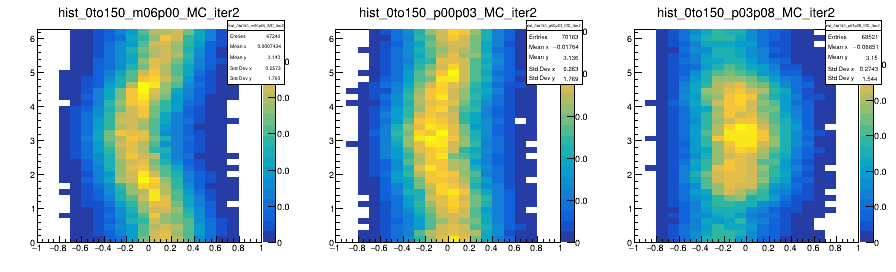

In [3]:
base_hists_pi0 = histMakerMC_pi0.builder.base_hists
can3 = TCanvas("can3","can3",900,300)
can3.Divide(3,1)
can3.Draw()
for i, hist in enumerate(base_hists_pi0[0]):
    if i < 3:
        can3.cd(i+1)
        if not isinstance(hist, list):
            hist.Draw("COLZ")
        else:
            print(hist)
can3.SaveAs("base_hists_pi0_MC.gif")


ASImage2gif():1010:<base_hists_rho_MC.gif> 
GIF-LIB undefined error 0.
Error in <TASImage::WriteImage>: error writing file base_hists_rho_MC.gif
Info in <TCanvas::Print>: gif file base_hists_rho_MC.gif has been created


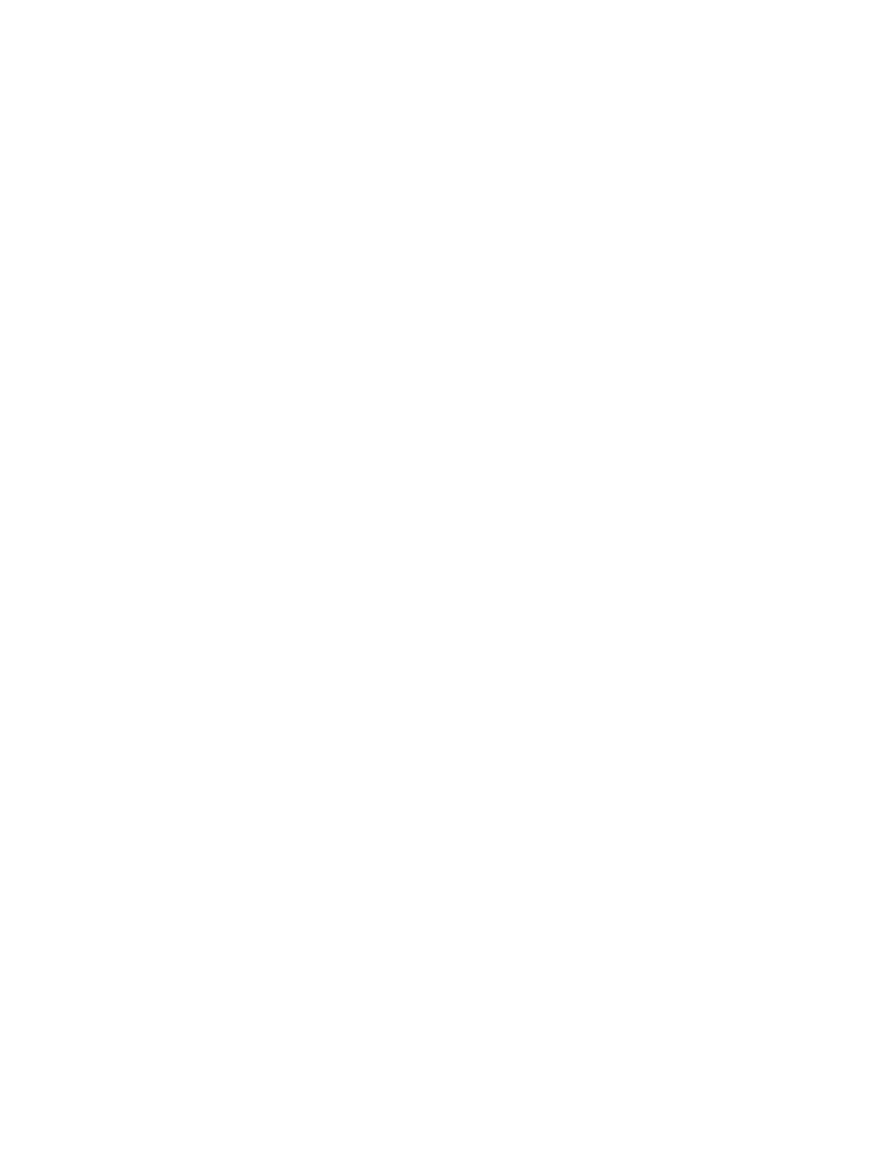

In [4]:
base_hists_rho = histMakerMC_rho.builder.base_hists
can5 = TCanvas("can5","can5",900,1200)
can5.Divide(3,4)
can5.Draw()
for i, hist in enumerate(base_hists_rho[0]):
    can3.cd(i+1)
    if not isinstance(hist, list):
        hist.Draw("COLZ")
    else:
        print(hist)
can5.SaveAs("base_hists_rho_MC.gif")


Info in <TCanvas::Print>: gif file histsData.gif has been created


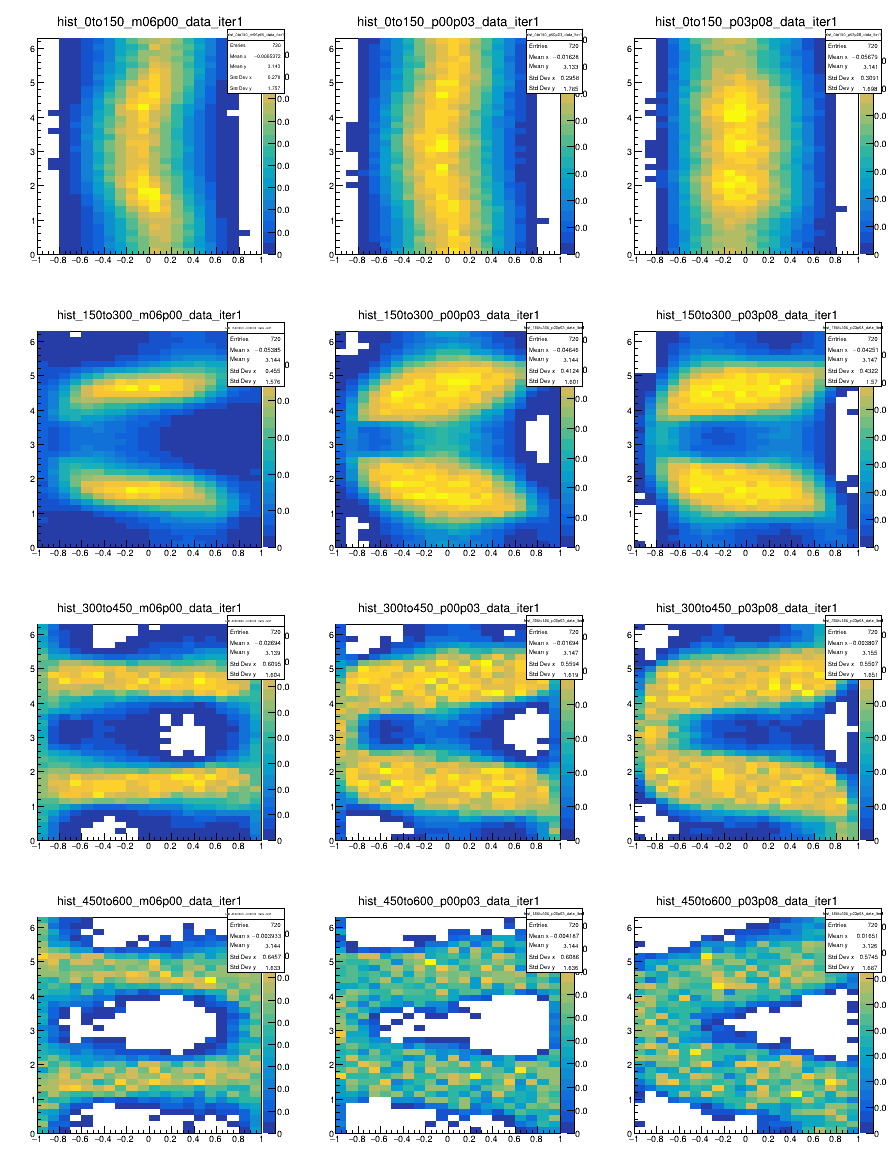

In [5]:
can4 = TCanvas("can4","can4",900,1200)
can4.Divide(3,4)
can4.Draw()
for i, hist in enumerate(histsData[0]):
    can4.cd(i+1)
    if not isinstance(hist, list):
        hist.Draw("COLZ")
    else:
        print(hist)

can4.SaveAs("histsData.gif")

In [6]:
import torch

torch.device("mps")
torch.manual_seed(0)

import gpytorch
import botorch

import matplotlib.pyplot as plt

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (8, 6)

from tqdm.notebook import tqdm

import warnings

In [7]:
TH1.SetDefaultSumw2

N_PARAMS = 3

In [8]:
torch.backends.mps.is_available()
#mps_device = torch.device("mps")
mps_device = torch.device("cpu")
bounds = torch.tensor([[0, 0,         0],
                       [1, 2*math.pi, 2]], dtype=torch.float)
bounds = bounds.to(mps_device)


grid_r   = torch.linspace(bounds[0][0], bounds[1][0], 101)
grid_phi = torch.linspace(bounds[0][1], bounds[1][1], 101)
grid_z   = torch.linspace(bounds[0][2], bounds[1][2], 101)

grid_x1, grid_x2, grid_x3 = torch.meshgrid(grid_r, grid_phi, grid_z, indexing="ij")

xs = torch.vstack([grid_x1.flatten(), grid_x2.flatten(), grid_x3.flatten()]).transpose(-2,-1)

In [9]:
class GPModel(gpytorch.models.ExactGP, botorch.models.gpytorch.GPyTorchModel):
# class GPModel(gpytorch.models.ApproximateGP, botorch.models.gpytorch.GPyTorchModel):
    _num_outputs = 1

    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=0.5, ard_num_dims=1)
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        mean_x = mean_x.to(mps_device)
        covar_x = covar_x.to(mps_device)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def fit_gp_model(train_x, train_y, num_train_iters=500):
    train_x = train_x.to(mps_device)
    train_y = train_y.to(mps_device)

    # declare the GP
    noise = 1e-2

   # likelihood = gpytorch.likelihoods.StudentTLikelihood()
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = GPModel(train_x, train_y, likelihood)
    model.likelihood.noise = noise
    likelihood = likelihood.to(mps_device)
    model = model.to(mps_device)

    # train the hyperparameter (the constant)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    model.train()
    likelihood.train()

    for i in range(num_train_iters):
        optimizer.zero_grad()

        output = model(train_x)
        loss = -mll(output, train_y)

        loss.backward()
        
        optimizer.step()

    model.eval()
    likelihood.eval()

    return model.cpu(), likelihood.cpu()

In [10]:
# TODO: Come back to standard version
num_queries = 75
#num_queries = 5
num_repeats = 1
num_samples = 150

In [11]:
def lambda_errors(xx, dxx):
    r, phi, z = xx[0], xx[1], xx[2]
    dr, dphi, dz = dxx[0], dxx[1], dxx[2]

    dlambda_theta_2 =     (dr * math.cos(phi)) ** 2 + (dphi * r * math.sin(phi)) ** 2 + (dz / 2) ** 2
    dlambda_phi_2   =     (dr * math.cos(phi) / 2) ** 2 + (dphi * r * math.sin(phi) / 2) ** 2 + (dz * 3 / 4) ** 2
    dlambda_theta_phi_2 = 0.5 * (dr * math.sin(phi)) ** 2 + 0.5 * (dphi * r * math.cos(phi)) ** 2

    dlambda_theta = math.sqrt(dlambda_theta_2)
    dlambda_phi = math.sqrt(dlambda_phi_2)
    dlambda_theta_phi = math.sqrt(dlambda_theta_phi_2)
    return dlambda_theta, dlambda_phi, dlambda_theta_phi

def lambdas(xx):
   # return x[0], x[1], x[2]
    r, phi, z = xx[0], xx[1], xx[2]
    x = r*math.cos(phi)
    y = r*math.sin(phi)
    lambda_theta = 0.5 * (2*x + z)
    lambda_phi   = 0.25 * (-2 - 2*x + 3*z)
    lambda_theta_phi = y/math.sqrt(2.)
    return lambda_theta, lambda_phi, lambda_theta_phi

def all_lambdas(xx):
    def generator(xx):
        for x in xx:
            lambda_theta, lambda_phi, lambda_theta_phi = lambdas(x)
            yield torch.tensor([lambda_theta, lambda_phi, lambda_theta_phi])
           # yield torch.tensor([1./(chi2 / ndf)])
    return torch.stack([a for a in generator(xx)])

In [12]:
from ipywidgets import interact, Layout, IntSlider, FloatSlider
import numpy as np

axis_titles = [r"R of cone coordinates", r"$\Phi$ of cone coordinates", r"Z of cone coordinates"]

def make_proj_2d(xs, tensor, transpose, index):
        tensor_3d = torch.reshape(tensor, (101,101,101))
        xs_3d = torch.reshape(xs, (101,101,101,3))

        if transpose:
               tensor_3d = tensor_3d.transpose(transpose[0],transpose[1])
               xs_3d     = xs_3d    .transpose(transpose[0],transpose[1])
        return xs_3d, tensor_3d[index]

def make_proj_1d(xs, tensor, transpose1, transpose2, index1, index2):
        tensor_3d = torch.reshape(tensor, (101,101,101))
        xs_3d = torch.reshape(xs, (101,101,101,3))

        if transpose1:
               tensor_3d = tensor_3d.transpose(transpose1[0],transpose1[1])
               xs_3d     = xs_3d    .transpose(transpose1[0],transpose1[1])
        if transpose2:
               tensor_3d = tensor_3d.transpose(transpose2[0],transpose2[1])
               xs_3d     = xs_3d    .transpose(transpose2[0],transpose2[1])
        return xs_3d, tensor_3d[index1][index2]

def oneplot(ax, tensor, index, cmap, title, transpose=None):
        
        global xs

        xs_3d, proj = make_proj_2d(xs, tensor, transpose, index)
        if transpose is None:
                extent=[
                        xs_3d[0][0][0][2],
                        xs_3d[0][0][-1][2],
                        xs_3d[0][0][0][1],
                        xs_3d[0][-1][0][1],
                ]
        elif transpose == (0,1):
                extent=[
                        xs_3d[0][0][0][2],
                        xs_3d[0][0][-1][2],
                        xs_3d[0][0][0][0],
                        xs_3d[0][-1][0][0],
                ]
        elif transpose == (0,2):
                extent=[
                        xs_3d[0][0][0][0],
                        xs_3d[0][0][-1][0],
                        xs_3d[0][0][0][1],
                        xs_3d[0][-1][0][1],
                ]
        if transpose is None:
                x_title=axis_titles[2]
                y_title=axis_titles[1]
        elif transpose == (0, 1):
                x_title=axis_titles[2]
                y_title=axis_titles[0]
        elif transpose == (0,2):
                x_title=axis_titles[0]
                y_title=axis_titles[1]
        
        pos = ax.imshow(proj, cmap=cmap, interpolation="nearest", origin="lower", 
                vmin=0, vmax=tensor.max(), extent=extent)
        ax.set_aspect((extent[1]-extent[0])/(extent[3]-extent[2]))
        ax.set_title(title)
        ax.set_xlabel(x_title)
        ax.set_ylabel(y_title)
        plt.colorbar(pos,fraction=0.046, pad=0.04)



def bin_index(x, scale):
        return int(x*100/scale)

def ff(ax, x, transpose, scale):
        cmap = "gist_rainbow"
        index = bin_index(x, scale)
        oneplot(ax, predictive_mean, index, cmap, r"ndf$/\chi^2$", transpose)
       # oneplot(ax[1], predictive_upper-predictive_lower, index, cmap, "confidence int. width", transpose)
       # oneplot(ax[1], acquisition_score, index, cmap, "acquisition score", transpose)
        
        return ax


def f(ax, x):
        return ff(ax, x, None, 1.0)
        
def g(ax, x):
        return ff(ax, x, (0,1),2*math.pi)

def h(ax x):
        return ff(ax, x, (0,2), 2.0)

gStyle.SetOptStat(0)

can_cmp_ind = 0

def plotComparison(histMC, histData):
    global can_cmp_ind

    can = TCanvas("can_cmp"+str(can_cmp_ind),"can",600,600)
    can_cmp_ind = can_cmp_ind+1
    can.Divide(2,2)
    can.Draw()
    can.cd(1)
    histMC.Draw("COLZ")
    can.cd(2)
    histData.Draw("COLZ")
    pad = can.cd(3)
    pad.SetRightMargin(0.155)
    pad = can.cd(3)
    hdiff = diffHist(histMC, histData)
    hdiff.Draw("COLZ")
    can.Update()
    palette = hdiff.GetListOfFunctions().FindObject("palette")
    palette.SetX1NDC(0.85)
    palette.SetX2NDC(0.9)
    can.Modified()
    can.Update()
    can.cd(4)
    nby = histMC.GetNbinsX()
    py = histMC.ProjectionY(histMC.GetName()+"py",1,nby)
    py.Draw("HIST")
    pyData = histData.ProjectionY("pyData",1,nby)
    pyData.SetLineColor(2)
    pyData.SetMarkerColor(2)
    pyData.Draw("SAME")
    return can, hdiff, py

In [13]:
# -2 is the default value when no feasible has been found
default_value = 0

def fit_bo(HIST_INDEX = 0):
    global bounds

    histMakerMC = histMakerMC_pi0 if HIST_INDEX < 3 else histMakerMC_rho

    def objective(xx):
        def generator(xx):
            for x in xx:
                lambda_theta, lambda_phi, lambda_theta_phi = lambdas(x)

                histsMC = histMakerMC.makeHists(lambda_theta, lambda_phi, lambda_theta_phi)
                chi2, ndf = calcOneChi2(histsMC[0][HIST_INDEX], histsData[0][HIST_INDEX])
                allHistsMC.append(histsMC[0][HIST_INDEX])
                if not chi2 or not ndf:
                    return torch.tensor([0])
                yield torch.tensor([1.0/(chi2 / ndf)])
        return torch.stack([a for a in generator(xx)])

    def one_starting_sample():
        result = bounds[0] + (bounds[1] - bounds[0]) * torch.rand(3)
        while -2.0*result[0] - 1.0*result[2] < -2:
            result = bounds[0] + (bounds[1] - bounds[0]) * torch.rand(3)
        return result

    feasible_incumbents = torch.ones((num_repeats, num_queries)) * default_value

    best_fs = []

    for trial in range(num_repeats):
        print("trial", trial)

        torch.manual_seed(trial)
       # train_x = bounds[0] + (bounds[1] - bounds[0]) * torch.rand(num_samples, 3)
       # while -2.0*train_x[0][0] - 1.0*train_x[0][2] < -2:
       #     train_x = bounds[0] + (bounds[1] - bounds[0]) * torch.rand(num_samples, 3)
        train_x = torch.stack([one_starting_sample() for _ in range(num_samples)])
        train_utility = objective(train_x).to(mps_device)
        train_x = train_x.to(mps_device)

        for i in tqdm(range(num_queries)):
            feasible_incumbents[trial, i] = train_utility.max()
            utility_model, utility_likelihood = fit_gp_model(
                train_x, train_utility.squeeze(-1)
            )
            best_f = train_utility.max()
            best_fs.append(best_f.item())
                
           # policy = botorch.acquisition.monte_carlo.qExpectedImprovement(
           # policy = botorch.acquisition.analytic.LogExpectedImprovement(
            policy = botorch.acquisition.logei.qLogExpectedImprovement(
          # policy = botorch.acquisition.analytic.LogProbabilityOfImprovement(
          # policy = botorch.acquisition.analytic.PosteriorMean(
                model=utility_model,
                best_f=train_utility.max(),
            ).to(mps_device)

            with warnings.catch_warnings():
                warnings.filterwarnings('ignore', category=RuntimeWarning)
                next_x, acq_val = botorch.optim.optimize_acqf(
                    policy,
                    bounds=bounds,
                    q=1,
                    num_restarts=40,
                    raw_samples=100,
                    inequality_constraints=[(torch.tensor([0,2],device=mps_device),torch.tensor([-2.0,-1.0],dtype=torch.float,device=mps_device),-2.0)],
                )

            next_utility = objective(next_x).to(mps_device)

            train_x = torch.cat([train_x, next_x])
            train_utility = torch.cat([train_utility, next_utility])
    torch.save(feasible_incumbents, f"./incumbents_" + str(HIST_INDEX) + ".pth")
    fout = TFile("out_"+str(HIST_INDEX)+".root","RECREATE")
    fout.cd()
    for hist in allHistsMC:
       # print ("Writing hist: ", hist.GetName())
        hist.Write()
    for j, hists in enumerate(histsData):
        for k, hist in enumerate(hists):
                hist.Write()
               # print ("Writing hist: ", j, k, hist)
    fout.Close()

    with torch.no_grad():
        predictive_distribution = utility_likelihood(utility_model(xs))
        predictive_mean = predictive_distribution.mean
        predictive_lower, predictive_upper = predictive_distribution.confidence_region()
        acquisition_score = policy(xs.unsqueeze(1))

    lds = all_lambdas(train_x)
    lambda_thetas     = lds.transpose(-2,-1)[0]
    lambda_phis       = lds.transpose(-2,-1)[1]
    lambda_theta_phis = lds.transpose(-2,-1)[2]
    c = torch.stack((
        torch.arange(0,num_queries, dtype=int),
        lambda_thetas[0:num_queries],
        lambda_phis[0:num_queries],
        lambda_theta_phis[0:num_queries],
        train_utility.squeeze()[0:num_queries],
        (feasible_incumbents==feasible_incumbents.max())[0],
        feasible_incumbents[0]
    ),0).transpose(-2,-1)
    torch.set_printoptions(precision=4,threshold=10_000, linewidth=120)
    sort_index = c[:, 4].sort()[1]
    c_sorted = c[sort_index]
    train_x_sorted = train_x[sort_index]

    return c_sorted, train_x_sorted, predictive_mean

In [14]:

def convert_to_h3d(predictive_mean, HIST_INDEX):
    pm = predictive_mean.reshape(101,101,101)
    pm_min = pm.min()
    hpm = TH3F("hpm","predictive mean", 101, 0, 1, 101, 0, 2*math.pi, 101, 0, 2)
    for binx in range(1,101):
        for biny in range(1,101):
            for binz in range(1,101):
                if pm_min < 0:
                    hpm.SetBinContent(binx,biny,binz,pm[binx][biny][binz].item()-pm_min)
                else:
                    hpm.SetBinContent(binx,biny,binz,pm[binx][biny][binz].item())
    hpm.SaveAs("pm_" + str(HIST_INDEX) + ".root")
    return hpm


In [15]:
def covariance_random_sampling(predictive_mean, HIST_INDEX):
    hpm = convert_to_h3d((predictive_mean, HIST_INDEX))

    from ctypes import c_double
    rnd_points = []

    x = c_double(0.0)
    y = c_double(0.0)
    z = c_double(0.0)
    for i in range(80_000_000):
        if i % 10000000 == 0:
            print(i)
        hpm.GetRandom3(x,y,z)
        rnd_points.append([x.value,y.value,z.value])

    print(x.value,y.value,z.value)
    covariance = np.cov(rnd_points, rowvar=False)
    return covariance

In [16]:
def covariance_weight(predictive_mean):
    predictive_mean_2 = predictive_mean - predictive_mean.min()

    covariance_2 = np.cov(xs, rowvar=False, aweights=predictive_mean_2)
    np.sqrt(covariance_2)

    return covariance_2

In [17]:
#cfit = TCanvas("cfit","cfit",500,500)
#cfit.Draw()
#cfit.cd()

def covariance_fit(hpm, best, HIST_INDEX):
    print(best)
    def gaus2d(X, a):
        N = a[0]
        m_x = a[1]
        m_y = a[2]

        K_xx = a[3]
        K_yy = a[4]

        K_xy = a[5]

        offset = a[6]

        x = X[0] - m_x
        y = X[1] - m_y

       # print(N, x, y, math.exp(-0.5*( x*x*K_xx + y*y*K_yy + 2*x*y*K_xy ) ) )
       
        return offset + N * math.exp( -0.5*(x*x*K_xx + y*y*K_yy + 2*x*y*K_xy) )

    def fit_2d(axis_ind):
        if axis_ind == 0:
            axis = hpm.GetXaxis()
            proj_option = "yz"
            proj_X_ind, proj_Y_ind = 2, 1
        elif axis_ind == 1:
            axis = hpm.GetYaxis()
            proj_option = "zx"
            proj_X_ind, proj_Y_ind = 0, 2
        else:
            axis = hpm.GetZaxis()
            proj_option = "xy"
            proj_X_ind, proj_Y_ind = 1, 0
        bin = axis.FindBin(best[axis_ind])
        axis.SetRange(bin, bin)
        
        proj = hpm.Project3D(proj_option)

        proj_lastbin_X = proj.GetXaxis().GetNbins()
        proj_max_X = proj.GetXaxis().GetBinUpEdge(proj_lastbin_X)
        proj_lastbin_Y = proj.GetYaxis().GetNbins()
        proj_max_Y = proj.GetYaxis().GetBinUpEdge(proj_lastbin_Y)
        scale_X = 0.2*proj_max_X
        scale_Y = 0.2*proj_max_Y

        xmin = min( best[proj_X_ind]-scale_X, 0.0)
        xmax = min( best[proj_X_ind]+scale_X, proj_max_X)
        ymin = min( best[proj_Y_ind]-scale_Y, 0.0)
        ymax = min( best[proj_Y_ind]+scale_Y, proj_max_Y)

        f2 = TF2("f2", gaus2d, xmin, xmax, ymin, ymax, 6)
        f2.SetParameter(0,1)
        f2.FixParameter(1,best[proj_X_ind])
        f2.FixParameter(2,best[proj_Y_ind])
        f2.SetParameter(3,0.2*best[proj_X_ind])
        f2.SetParameter(4,0.2*best[proj_Y_ind])
        f2.SetParameter(5,0)
        f2.SetParameter(6,0)

        print("type of proj", type(proj))
        print("type of f2", type(f2))
        proj.Fit(f2,"R0")
    
        return f2.GetParameter(3), f2.GetParameter(4), f2.GetParameter(5)

    params0 = fit_2d(0)
    params1 = fit_2d(1)
    params2 = fit_2d(2)

    params = np.array([params0,params1,params2])
    print(params)


In [18]:
def covariance_fit_scipy(predictive_mean, best, HIST_INDEX):
    def gaus1d(x, A, mean_x, sigma_x, offset):
        x = x - mean_x
        z = offset + A * np.exp( -0.5 * (x/sigma_x) ** 2 )
        return z

   # def gaus2d(X, A, mean_x, mean_y, K_xx, K_yy, K_xy, offset):
    def gaus2d(X, A, mean_x, mean_y, K_xx, K_yy, K_xy, offset):
        (x, y) = X
        x = x - mean_x
        y = y - mean_y
       # print("HERE 1: ", A, K_xx, x, K_yy, y, K_xy)
       # print("HERE 2: ", K_xx * x **2, K_yy * y **2, K_xy * x * y)
       # print("HERE 3: ", offset + np.exp( -0.5*(K_xx * x ** 2 + K_yy * y ** 2 + 2 * K_xy * x * y) ))
        z = offset + A * np.exp( -0.5*(K_xx * x ** 2 + K_yy * y ** 2 + 2 * K_xy * x * y) )
       # print("z SHAPE: ", z.shape)
       # print("z.ravel() SHAPE: ", z.ravel().shape)
       # return z.ravel()
        return z

    def gaus3d(X, A, mean_x, mean_y, mean_z, K_xx, K_yy, K_zz, K_xy, K_yz, K_zx, offset):
        (x, y, z) = X
        x = x - mean_x
        y = y - mean_y
        z = z - mean_z
        z = offset + A * np.exp( -0.5*(K_xx * x ** 2 + K_yy * y ** 2 + K_zz * z ** 2 + 
            2 * K_xy * x * y + 2 * K_yz * y * z + 2 * K_zx * z * x) )
        return z

    def gaus2d_fixed_mean(mean_x, mean_y):
        def inner(X, A, K_xx, K_yy, K_xy, offset):
            (x, y) = X
            x = x - mean_x
            y = y - mean_y
            z = offset + A * np.exp( -0.5*(K_xx * x ** 2 + K_yy * y ** 2 + 2 * K_xy * x * y) )
            return z
        return inner

    def gaus3d_fixed_mean(mean_x, mean_y, mean_z):
        def inner(X, A, K_xx, K_yy, K_zz, K_xy, K_yz, K_zx, offset):
            (x, y, z) = X
            x = x - mean_x
            y = y - mean_y
            z = z - mean_z
            z = offset + A * np.exp( -0.5*(K_xx * x ** 2 + K_yy * y ** 2 + K_zz * z ** 2 + 
                2 * K_xy * x * y + 2 * K_yz * y * z + 2 * K_zx * z * x) )
            return z
        return inner

    def fit_1d(axis_ind, ax):
        if axis_ind == 0:
            axis1, axis2 = 1, 2
            trasnpose1, transpose2 = (0, 1), (1, 2)
        elif axis_ind == 1:
            axis1, axis2 = 2, 0
            trasnpose1, transpose2 = (0, 1), (0, 2)
        else:
            axis1, axis2 = 0, 1
            trasnpose1, transpose2 = None, None

        mean_x = best[axis_ind].item()

        scale1 = bounds[1][axis1].item()
        scale2 = bounds[1][axis2].item()
        proj_max_X = bounds[1][axis_ind].item()

        index1 = bin_index(train_x_sorted[-1][axis1], scale1)
        index2 = bin_index(train_x_sorted[-1][axis2], scale2)
        _, proj = make_proj_1d(xs, predictive_mean, trasnpose1, transpose2, index1, index2)

        xmin_ind = max(0,   bin_index(mean_x, proj_max_X)-30)
        xmax_ind = min(100, bin_index(mean_x, proj_max_X)+30)
        xmin = xmin_ind / 100. * proj_max_X
        xmax = (xmax_ind + 1) / 100. * proj_max_X

        x = np.linspace(0, proj_max_X, 101)
       # fig, ax = plt.subplots(nrows=1, ncols=1, sharey=False)
        ax.plot(x, proj, label="Estimated values")
        ax.set_xlabel(axis_titles[axis_ind])
        ax.set_ylabel(r"ndf$/\chi^2$")
        proj1 = proj[xmin_ind:xmax_ind]
    
        initial_guess = (1.0, mean_x, 0.2*proj_max_X, 0.0)

        popt, pcov = opt.curve_fit(gaus1d, x[xmin_ind:xmax_ind], proj1, p0 = initial_guess)
        fit_result = gaus1d(x, *(popt))
        ax.plot(x, fit_result, label="Gaussian fit")
        ax.set_xlabel(axis_titles[axis_ind])
        ax.set_ylabel(r"ndf$/\chi^2$")
        ax.legend()
        return popt, pcov


    def fit_2d(axis_ind):
        if axis_ind == 0:
            trasnpose = None
            proj_X_ind, proj_Y_ind = 2, 1
        elif axis_ind == 1:
            trasnpose = (0, 1)
            proj_X_ind, proj_Y_ind = 0, 2
        else:
            trasnpose = (0, 2)
            proj_X_ind, proj_Y_ind = 0, 1

        mean_x = best[proj_X_ind].item()
        mean_y = best[proj_Y_ind].item()

        scale = bounds[1][axis_ind].item()
        proj_max_X = bounds[1][proj_X_ind].item()
        proj_max_Y = bounds[1][proj_Y_ind].item()

        index = bin_index(train_x_sorted[-1][axis_ind], scale)
        _, proj = make_proj_2d(xs, predictive_mean, trasnpose, index)

        xmin_ind = max(0,   bin_index(mean_x, proj_max_X)-30)
        xmax_ind = min(100, bin_index(mean_x, proj_max_X)+30)
        ymin_ind = max(0,   bin_index(mean_y, proj_max_Y)-30)
        ymax_ind = min(100, bin_index(mean_y, proj_max_Y)+30)
        xmin = xmin_ind / 100. * proj_max_X
        xmax = (xmax_ind + 1) / 100. * proj_max_X
        ymin = ymin_ind / 100. * proj_max_Y
        ymax = (ymax_ind + 1) / 100. * proj_max_Y

        fig, ax = plt.subplots(nrows=1, ncols=3, sharey=False)
        ax[0].imshow(proj, interpolation="nearest", origin="lower", cmap="gist_rainbow",
            aspect=proj_max_X/proj_max_Y,
            vmin=0, vmax=predictive_mean.max(), extent=(0,proj_max_X,0,proj_max_Y))
        proj1 = proj[ymin_ind:ymax_ind, xmin_ind:xmax_ind]

       # initial_guess = (1.0, mean_x, mean_y, 0.2*proj_max_X, 0.2*proj_max_Y, 0.0, 0.0)
        initial_guess = (1.0, 0.2*proj_max_X, 0.2*proj_max_Y, 0.0, 0.0)
    
        x = np.linspace(xmin, xmax, xmax_ind-xmin_ind)
        y = np.linspace(ymin, ymax, ymax_ind-ymin_ind)
        x, y = np.meshgrid(x, y)
        x = x.flatten()
        y = y.flatten()

        ax[1].imshow(proj1, interpolation="nearest", origin="lower", cmap="gist_rainbow",
            aspect=(xmax-xmin)/(ymax-ymin),
            vmin=0, vmax=predictive_mean.max(), extent=(xmin,xmax,ymin,ymax))
        popt, pcov = opt.curve_fit(gaus2d_fixed_mean(mean_x, mean_y), (x,y), proj1.ravel(), p0 = initial_guess)
        fit_result = gaus2d_fixed_mean(mean_x, mean_y)((x,y), *(popt)).reshape(ymax_ind-ymin_ind,xmax_ind-xmin_ind)
        ax[2].imshow(fit_result, interpolation="nearest", origin="lower", cmap="gist_rainbow",
            aspect=(xmax-xmin)/(ymax-ymin),
            vmin=0, vmax=predictive_mean.max(), extent=(xmin,xmax,ymin,ymax))
        return popt, pcov

    def fit_3d():
        mean_x = best[0].item()
        mean_y = best[1].item()
        mean_z = best[2].item()
        
        proj_max_X = bounds[1][0].item()
        proj_max_Y = bounds[1][1].item()
        proj_max_Z = bounds[1][2].item()

        xmin_ind = max(0,   bin_index(mean_x, proj_max_X)-30)
        xmax_ind = min(100, bin_index(mean_x, proj_max_X)+30)
        ymin_ind = max(0,   bin_index(mean_y, proj_max_Y)-30)
        ymax_ind = min(100, bin_index(mean_y, proj_max_Y)+30)
        zmin_ind = max(0,   bin_index(mean_z, proj_max_Z)-30)
        zmax_ind = min(100, bin_index(mean_z, proj_max_Z)+30)
        xmin = xmin_ind / 100. * proj_max_X
        xmax = (xmax_ind + 1) / 100. * proj_max_X
        ymin = ymin_ind / 100. * proj_max_Y
        ymax = (ymax_ind + 1) / 100. * proj_max_Y
        zmin = zmin_ind / 100. * proj_max_Z
        zmax = (zmax_ind + 1) / 100. * proj_max_Z

        predictive_mean1 = predictive_mean.reshape(101,101,101)
        predictive_mean1 = predictive_mean1[xmin_ind:xmax_ind,ymin_ind:ymax_ind,zmin_ind:zmax_ind]

       # initial_guess = (1.0, mean_x, mean_y, mean_z, 0.2*proj_max_X, 0.2*proj_max_Y, 0.2*proj_max_Z, 0.0, 0.0, 0.0, 0.0)
        initial_guess = (1.0, 0.2*proj_max_X, 0.2*proj_max_Y, 0.2*proj_max_Z, 0.0, 0.0, 0.0, 0.0)
    
        x = np.linspace(xmin, xmax, xmax_ind-xmin_ind)
        y = np.linspace(ymin, ymax, ymax_ind-ymin_ind)
        z = np.linspace(zmin, zmax, zmax_ind-zmin_ind)
        x, y, z = np.meshgrid(x, y, z)
        x = x.flatten()
        y = y.flatten()
        z = z.flatten()

        popt, pcov = opt.curve_fit(gaus3d_fixed_mean(mean_x, mean_y, mean_z), (x,y,z), predictive_mean1.ravel(), p0 = initial_guess)
        return popt, pcov

    fig, ax = plt.subplots(nrows=1, ncols=3, sharey=False)
    params0, _ = fit_1d(0, ax[0])
   # print("params0: ", params0)
    params1, _ = fit_1d(1, ax[1])
   # print("params1: ", params1)
    params2, _ = fit_1d(2, ax[2])
   # print("params2: ", params2)

    return params0[2], params1[2], params2[2]


### A, mean_x, mean_y, mean_z, K_xx, K_yy, K_zz, K_xy, K_yz, K_zx, offset
   # params, _ = fit_3d()

   # print("PARAMS: ", params)
   # PARAM_OFFSET=-3

   # K_RR = params[4+PARAM_OFFSET]
   # K_PhiPhi = params[5+PARAM_OFFSET]
   # K_ZZ = params[6+PARAM_OFFSET]    
   # K_ZPhi = params[7+PARAM_OFFSET]
   # K_ZR = params[8+PARAM_OFFSET]
   # K_RPhi = params[9+PARAM_OFFSET]

   # K = np.array([
   #     [K_RR,   K_RPhi,   K_ZR],
   #     [K_RPhi, K_PhiPhi, K_ZPhi],
   #     [K_ZR,   K_ZPhi,   K_ZZ]
   # ])

   # print("K 1: ", K)
   # Sigma = np.linalg.inv(K)
   # print("COVARIANCE 1: ", Sigma)

   # PARAM_OFFSET=-2
   
   # params0, _ = fit_2d(0)
   # print("params0: ", params0[3+PARAM_OFFSET:6+PARAM_OFFSET])
   # params1, _ = fit_2d(1)
   # print("params1: ", params1[3+PARAM_OFFSET:6+PARAM_OFFSET])
   # params2, _ = fit_2d(2)
   # print("params2: ", params2[3+PARAM_OFFSET:6+PARAM_OFFSET])

   # K_RR_a, K_RR_b = params2[3+PARAM_OFFSET], params1[4+PARAM_OFFSET]
   # K_PhiPhi_a, K_PhiPhi_b = params0[4+PARAM_OFFSET], params2[4+PARAM_OFFSET]
   # K_ZZ_a, K_ZZ_b = params0[3+PARAM_OFFSET], params1[3+PARAM_OFFSET]
   # K_RR = 0.5*(K_RR_a + K_RR_b)
   # K_PhiPhi = 0.5*(K_PhiPhi_a + K_PhiPhi_b)
   # K_ZZ = 0.5*(K_ZZ_a + K_ZZ_b)
   # K_ZPhi = params0[5+PARAM_OFFSET]
   # K_ZR = params1[5+PARAM_OFFSET]
   # K_RPhi = params2[5+PARAM_OFFSET]

   # K = np.array([
   #     [K_RR,   K_RPhi,   K_ZR],
   #     [K_RPhi, K_PhiPhi, K_ZPhi],
   #     [K_ZR,   K_ZPhi,   K_ZZ]
   # ])
   # print("K 2: ", K)
   # Sigma = np.linalg.inv(K)
   # print("COVARIANCE 2: ", Sigma)

trial 0


  0%|          | 0/75 [00:00<?, ?it/s]

tensor([[ 5.8000e+01,  1.9811e-01, -8.5534e-02, -3.9878e-01,  7.3549e-02,  1.0000e+00,  1.1133e-01],
        [ 6.6000e+01,  8.9580e-01,  9.3417e-02, -1.3611e-01,  7.5050e-02,  1.0000e+00,  1.1133e-01],
        [ 4.1000e+01,  4.4347e-01, -8.1201e-02, -1.1996e-01,  7.8041e-02,  0.0000e+00,  1.1132e-01],
        [ 6.0000e+01,  1.9347e-01,  6.3436e-02, -4.0499e-01,  8.3121e-02,  1.0000e+00,  1.1133e-01],
        [ 2.0000e+00,  8.4559e-01, -1.1538e-02, -2.0991e-01,  1.0045e-01,  0.0000e+00,  1.0780e-01]])
0: Final result:
0: lambdas =  tensor([ 0.8456, -0.0115, -0.2099])
0: errors =  (0.29767311879415226, 0.2505482979125348, 0.18861081969752558)
trial 0


  0%|          | 0/75 [00:00<?, ?it/s]

tensor([[ 5.7000e+01,  7.9179e-01, -5.0049e-02,  1.6577e-01,  7.5406e-02,  0.0000e+00,  1.1608e-01],
        [ 5.4000e+01,  2.9609e-01,  1.5700e-02, -8.6745e-02,  7.7546e-02,  0.0000e+00,  1.1608e-01],
        [ 4.1000e+01,  4.4347e-01, -8.1201e-02, -1.1996e-01,  8.0944e-02,  0.0000e+00,  1.1584e-01],
        [ 6.6000e+01,  8.9580e-01,  9.3417e-02, -1.3611e-01,  9.3990e-02,  1.0000e+00,  1.1610e-01],
        [ 2.0000e+00,  8.4559e-01, -1.1538e-02, -2.0991e-01,  1.1039e-01,  0.0000e+00,  1.1143e-01]])
1: Final result:
1: lambdas =  tensor([ 0.8456, -0.0115, -0.2099])
1: errors =  (0.3314744431884356, 0.26415093312406457, 0.24620981355677177)
trial 0


  0%|          | 0/75 [00:00<?, ?it/s]

tensor([[ 3.0000e+00,  3.0478e-01, -6.4615e-02,  1.3779e-02,  2.6958e-02,  0.0000e+00,  2.9266e-02],
        [ 7.3000e+01,  3.2307e-01, -6.1559e-02, -9.5715e-03,  2.7046e-02,  1.0000e+00,  3.0834e-02],
        [ 2.0000e+00,  8.4559e-01, -1.1538e-02, -2.0991e-01,  2.7158e-02,  0.0000e+00,  2.9266e-02],
        [ 4.1000e+01,  4.4347e-01, -8.1201e-02, -1.1996e-01,  2.7174e-02,  0.0000e+00,  3.0656e-02],
        [ 5.7000e+01,  7.9179e-01, -5.0049e-02,  1.6577e-01,  2.9116e-02,  1.0000e+00,  3.0834e-02]])
2: Final result:
2: lambdas =  tensor([ 0.7918, -0.0500,  0.1658])
2: errors =  (0.41235123899654613, 0.31255518902773594, 0.3348876272336208)
trial 0


  0%|          | 0/75 [00:00<?, ?it/s]

tensor([[ 4.1000e+01,  4.4347e-01, -8.1201e-02, -1.1996e-01,  1.4821e-01,  0.0000e+00,  1.9156e-01],
        [ 7.3000e+01,  3.2307e-01, -6.1559e-02, -9.5715e-03,  1.7306e-01,  1.0000e+00,  1.9183e-01],
        [ 4.8000e+01,  3.4236e-01, -2.4728e-01,  1.5894e-01,  1.7561e-01,  0.0000e+00,  1.9172e-01],
        [ 3.0000e+00,  3.0478e-01, -6.4615e-02,  1.3779e-02,  1.7677e-01,  0.0000e+00,  1.9067e-01],
        [ 1.1000e+01,  3.0575e-01, -1.6946e-01,  6.5269e-02,  1.8986e-01,  0.0000e+00,  1.9121e-01]])


/var/folders/96/myz9b61s4gx36c78ytymzp9h0000gn/T/ipykernel_8950/3344684529.py:79: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(nrows=1, ncols=1, sharey=True)


3: Final result:
3: lambdas =  tensor([ 0.3058, -0.1695,  0.0653])
3: errors =  (0.16931316262175716, 0.20432463688887567, 0.10674634852378785)
trial 0


  0%|          | 0/75 [00:00<?, ?it/s]

tensor([[ 3.0000e+00,  3.0478e-01, -6.4615e-02,  1.3779e-02,  1.2483e-01,  0.0000e+00,  1.6330e-01],
        [ 5.0000e+00,  3.8773e-01,  5.2969e-02,  2.3484e-02,  1.2889e-01,  0.0000e+00,  1.6388e-01],
        [ 6.7000e+01,  2.9144e-01,  8.2835e-02,  8.9792e-02,  1.3887e-01,  1.0000e+00,  1.7092e-01],
        [ 6.3000e+01, -1.8964e-01,  3.1108e-02,  2.6876e-01,  1.4555e-01,  0.0000e+00,  1.7043e-01],
        [ 2.3000e+01,  3.0991e-01, -4.7896e-03,  2.6483e-01,  1.5874e-01,  0.0000e+00,  1.6759e-01]])
4: Final result:
4: lambdas =  tensor([ 0.3099, -0.0048,  0.2648])
4: errors =  (0.22023605616679903, 0.23603585984516193, 0.14452148739603193)
trial 0


  0%|          | 0/75 [00:00<?, ?it/s]

tensor([[ 5.9000e+01,  2.0891e-01,  4.4981e-02, -1.0347e-01,  7.3470e-02,  0.0000e+00,  1.2216e-01],
        [ 2.1000e+01, -4.2789e-01,  2.2602e-01, -9.2096e-02,  7.7461e-02,  0.0000e+00,  1.2200e-01],
        [ 6.7000e+01,  2.9144e-01,  8.2835e-02,  8.9792e-02,  7.7887e-02,  1.0000e+00,  1.2224e-01],
        [ 2.0000e+01, -1.2562e-01,  1.5328e-01, -1.5180e-01,  8.2148e-02,  0.0000e+00,  1.2200e-01],
        [ 3.0000e+01,  1.5735e-01,  2.2498e-01,  1.1957e-01,  9.2571e-02,  0.0000e+00,  1.2214e-01]])
5: Final result:
5: lambdas =  tensor([0.1573, 0.2250, 0.1196])
5: errors =  (0.2916679240381295, 0.2749365722595504, 0.17171938310320758)


Warning in <TROOT::Append>: Replacing existing TH1: hist_0to150_m06p00_MC_iter2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_0to150_p00p03_MC_iter2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_0to150_p03p08_MC_iter2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_150to300_m06p00_MC_iter2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_150to300_p00p03_MC_iter2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_150to300_p03p08_MC_iter2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_300to450_m06p00_MC_iter2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_300to450_p00p03_MC_iter2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_300to450_p03p08_MC_iter2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing exist

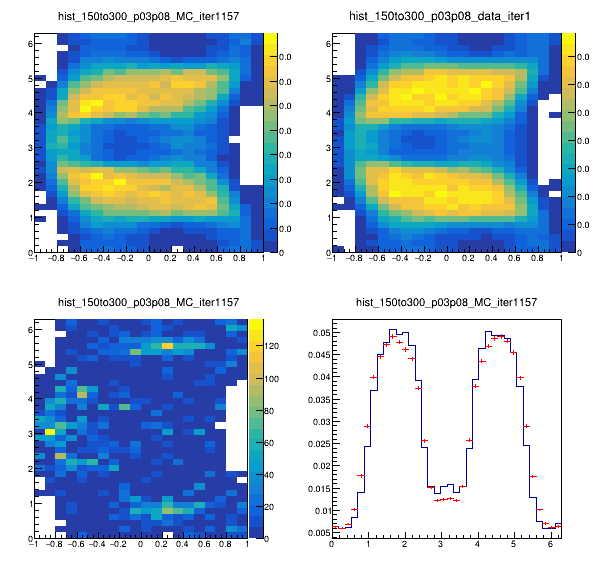

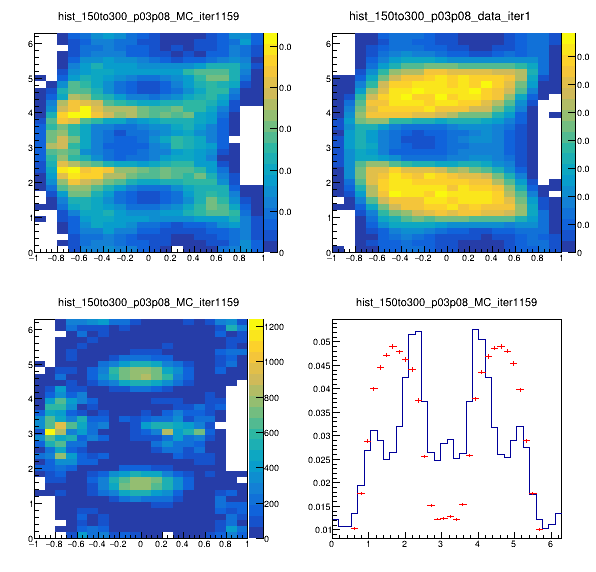

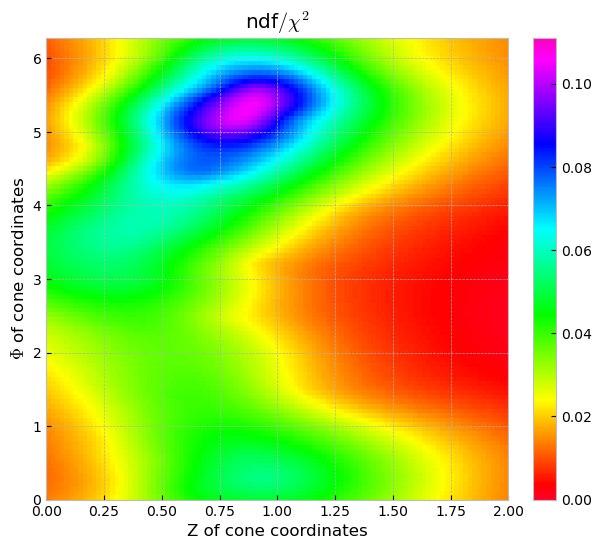

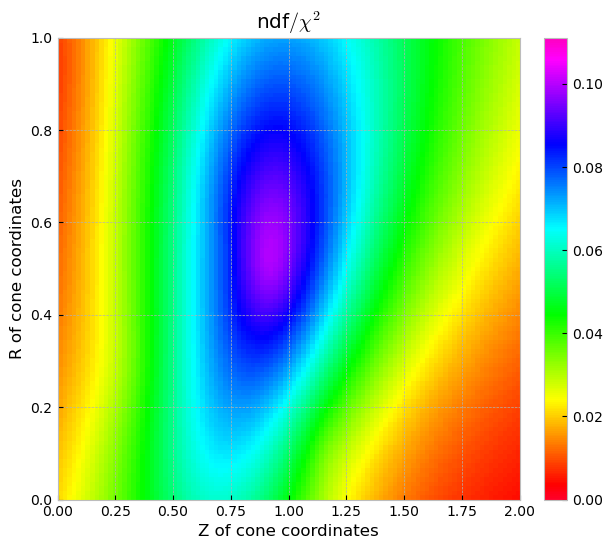

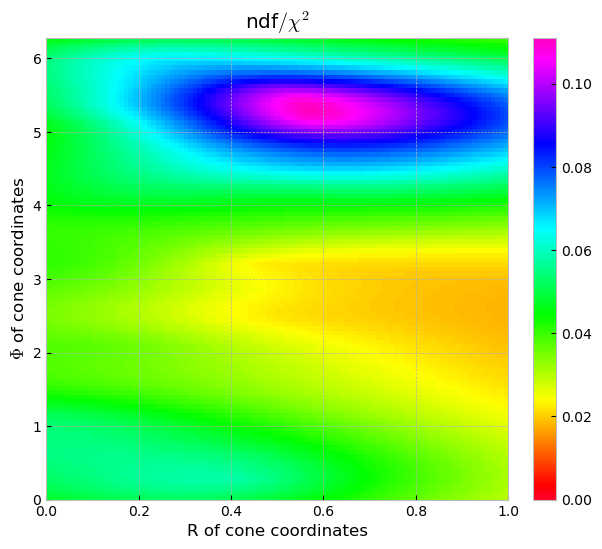

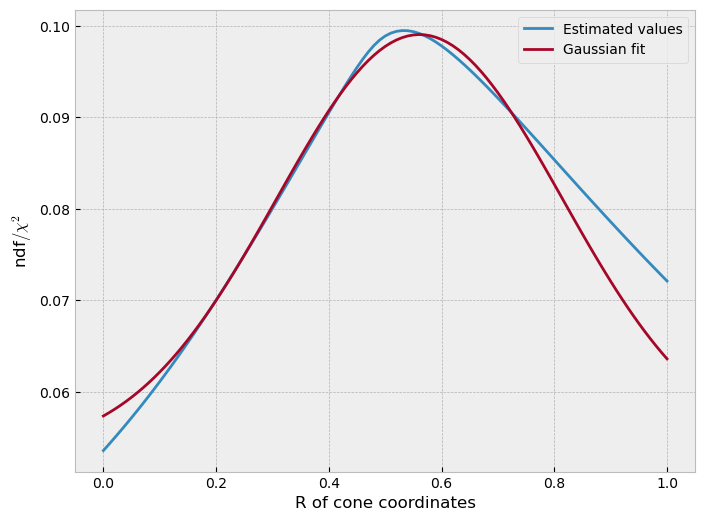

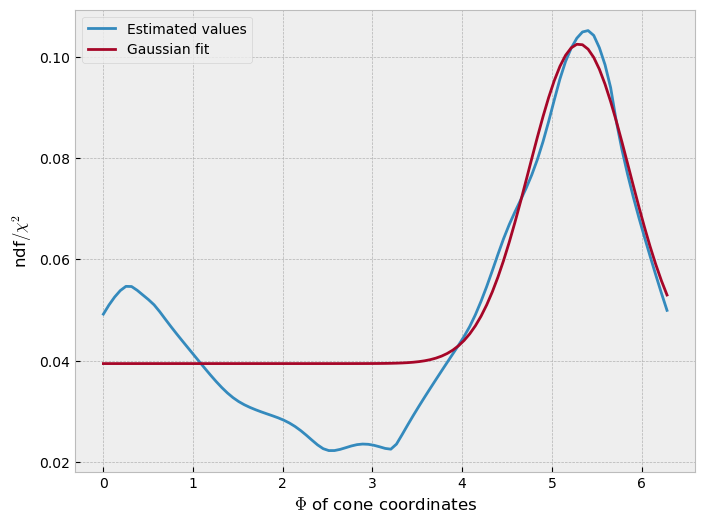

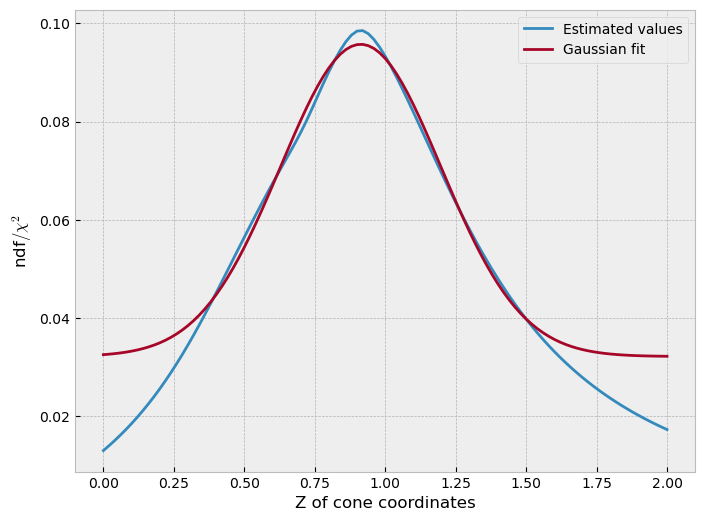

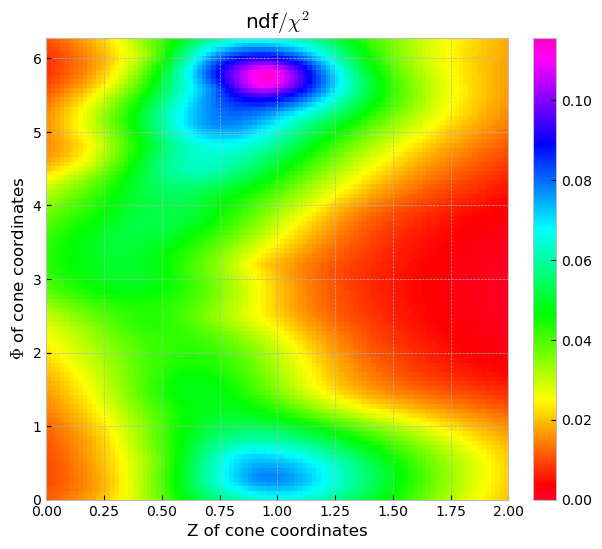

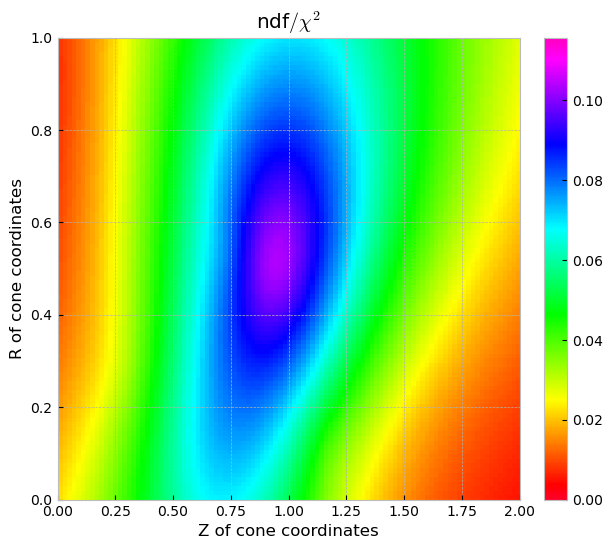

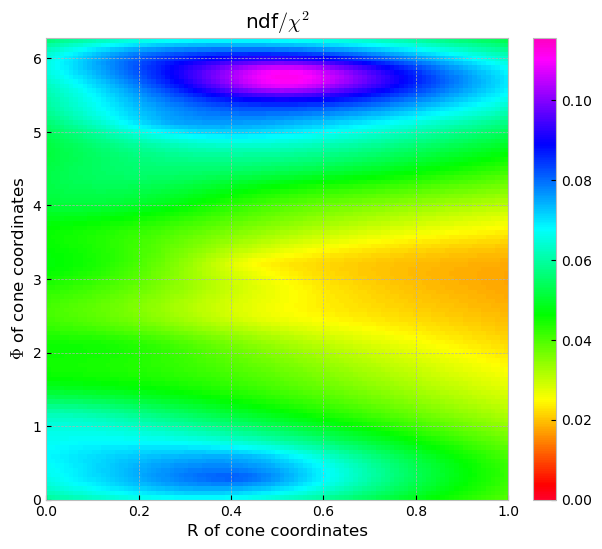

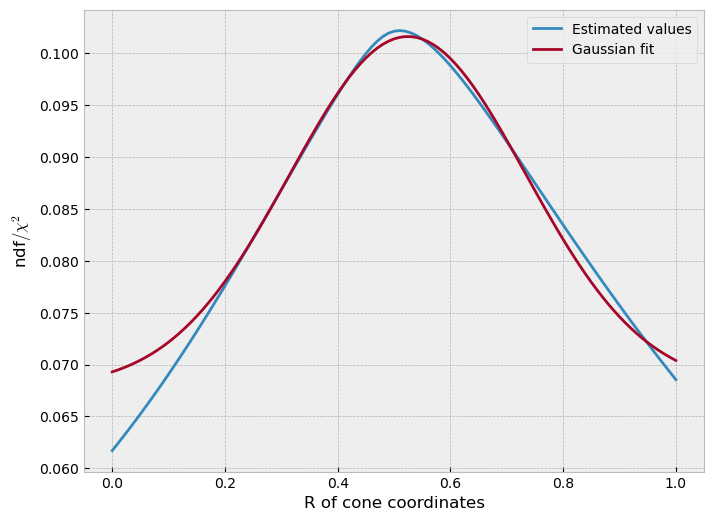

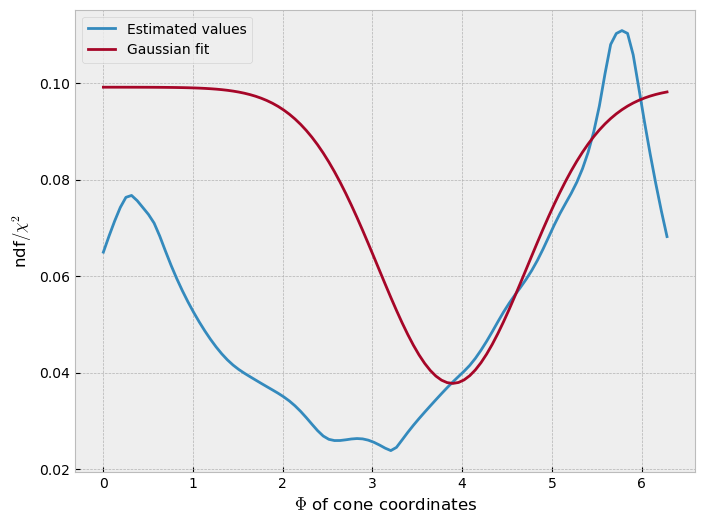

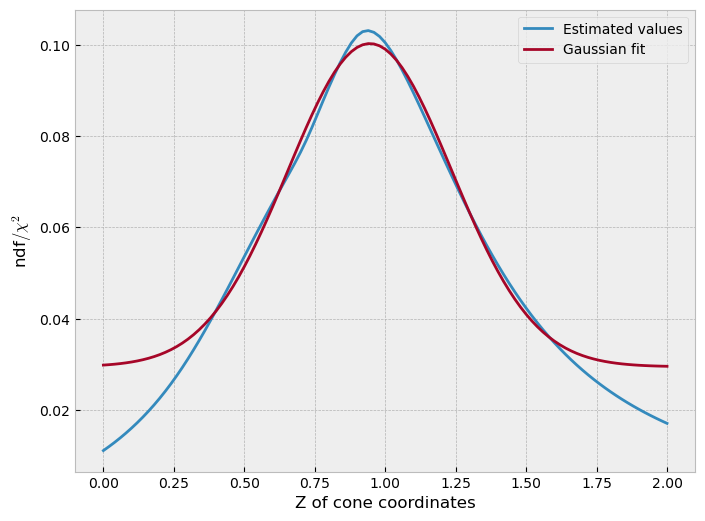

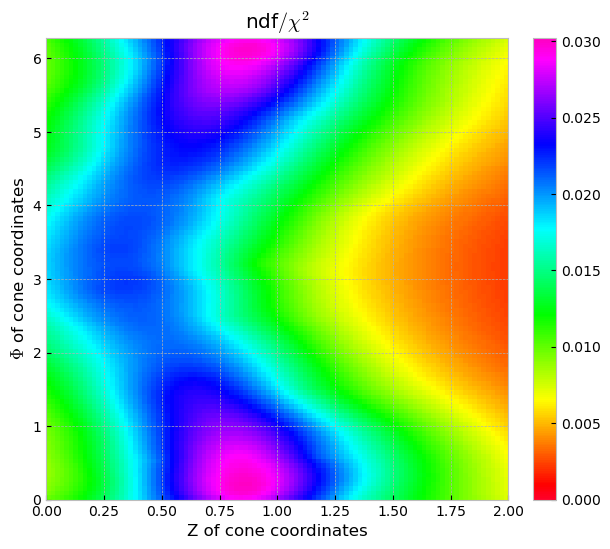

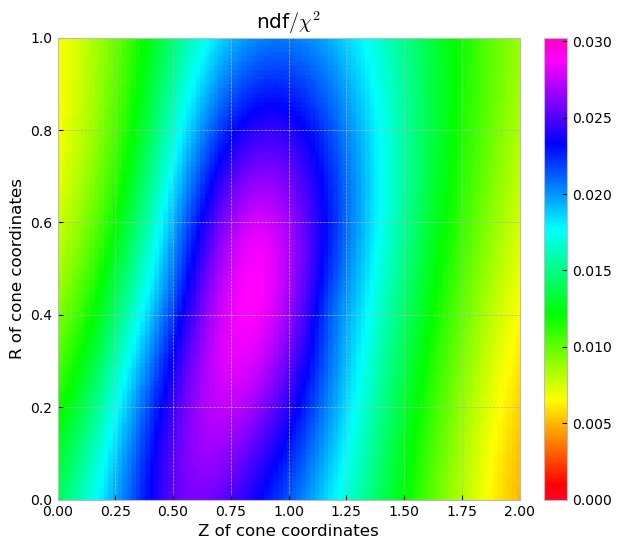

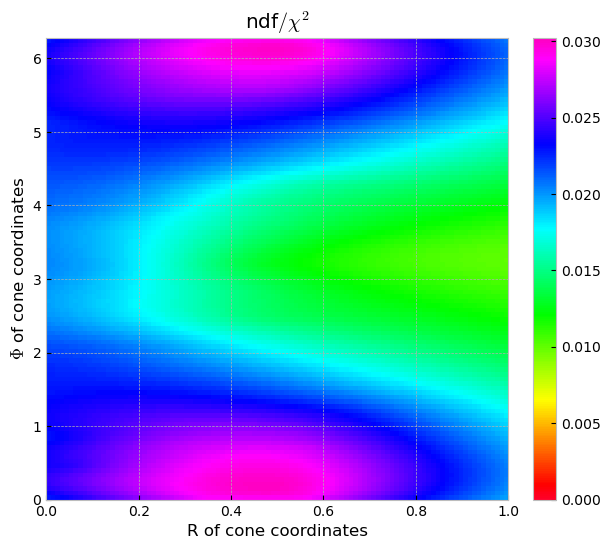

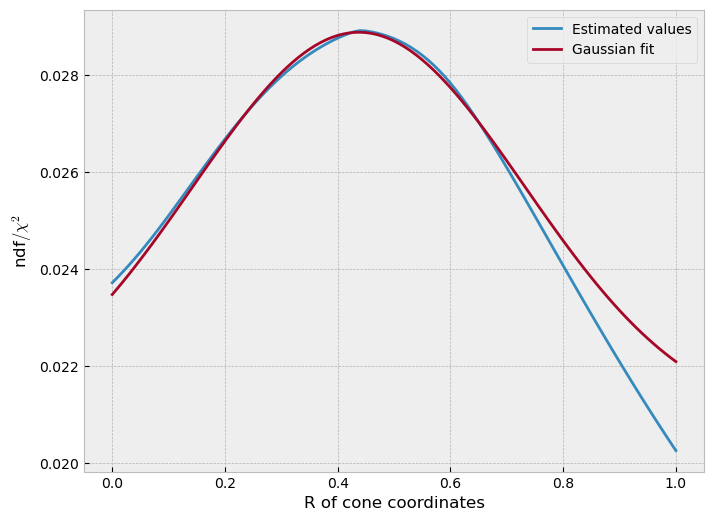

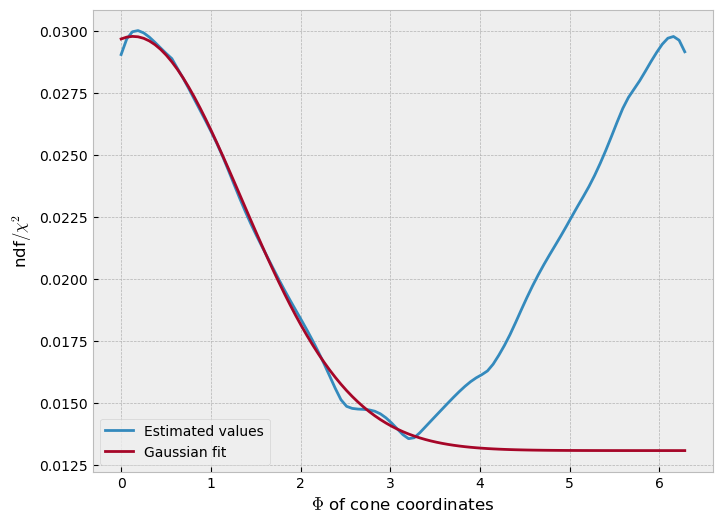

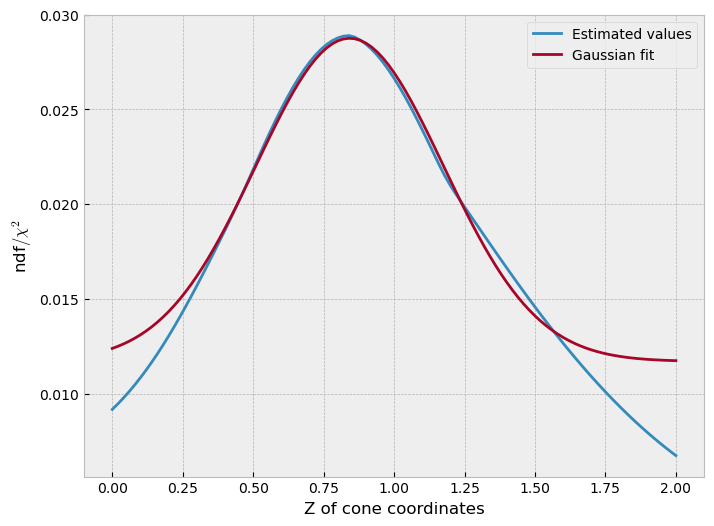

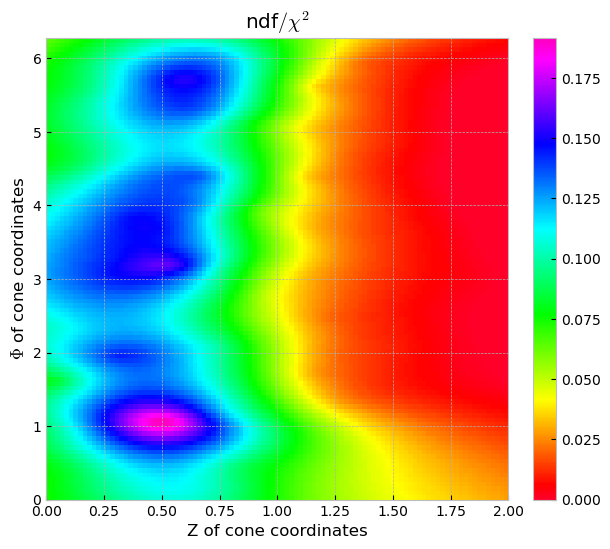

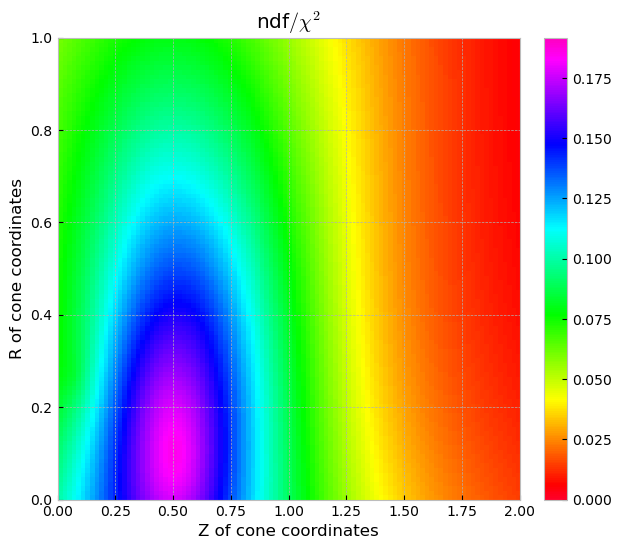

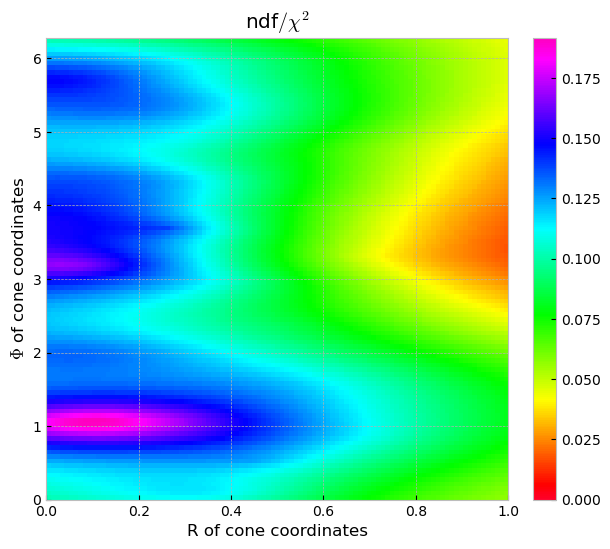

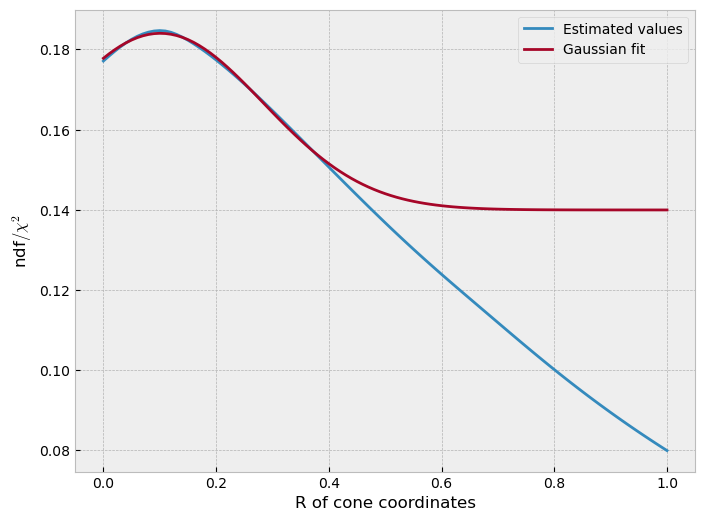

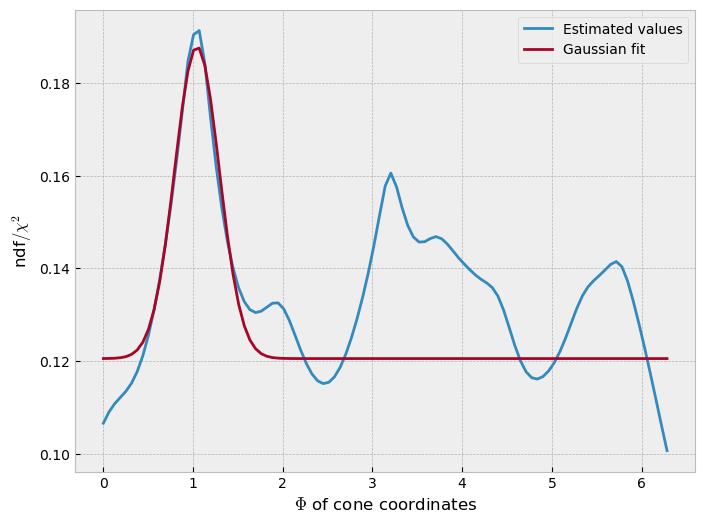

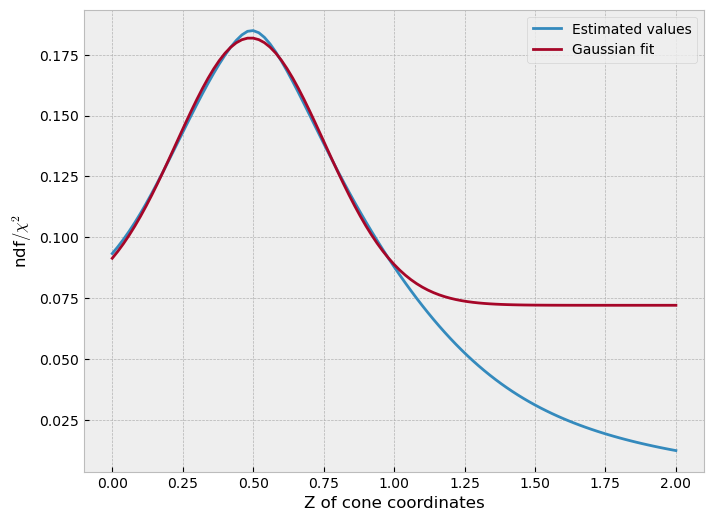

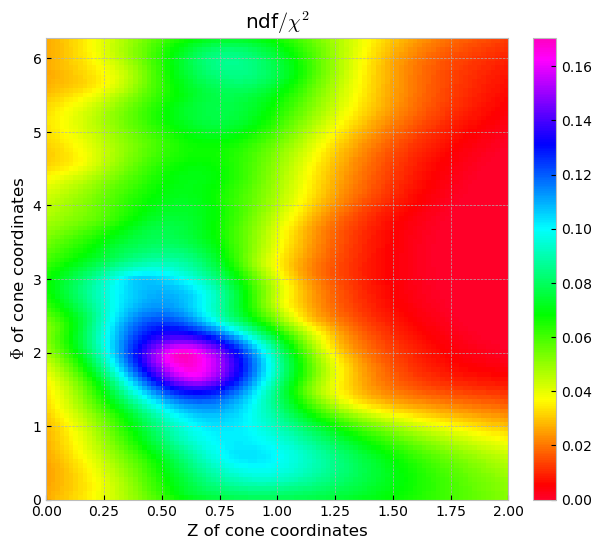

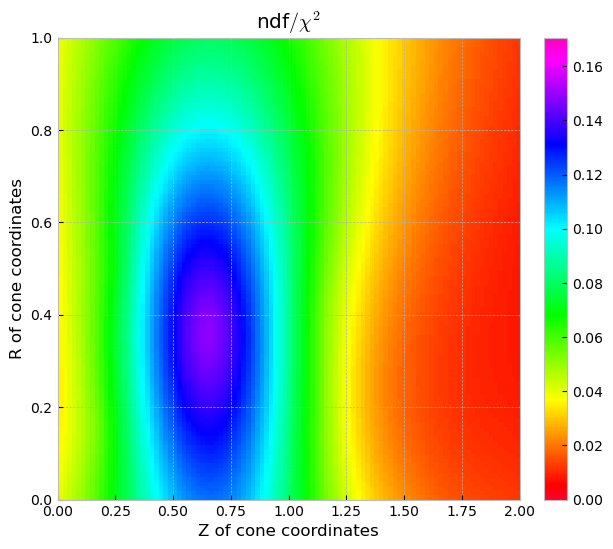

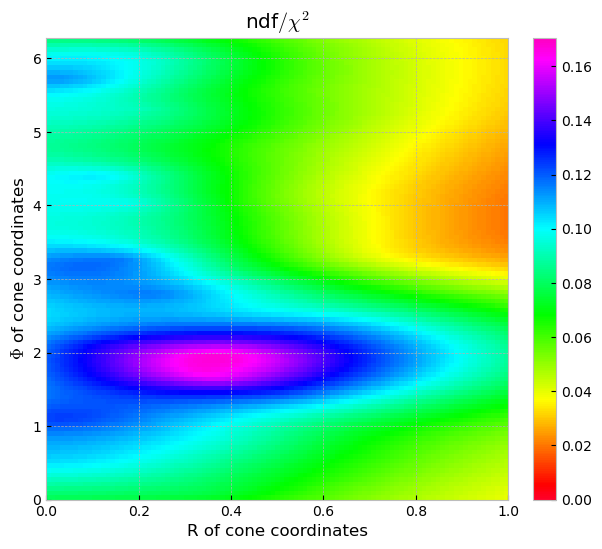

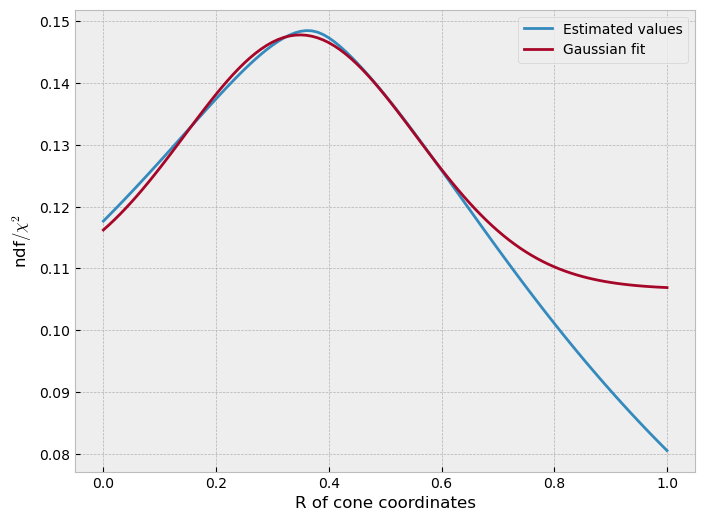

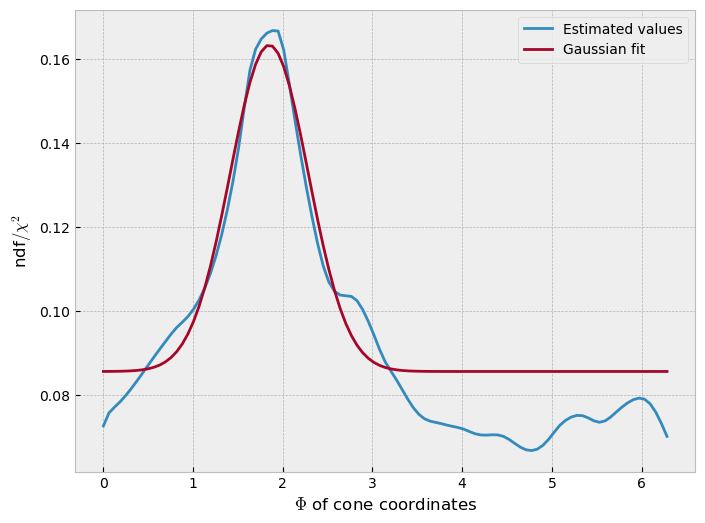

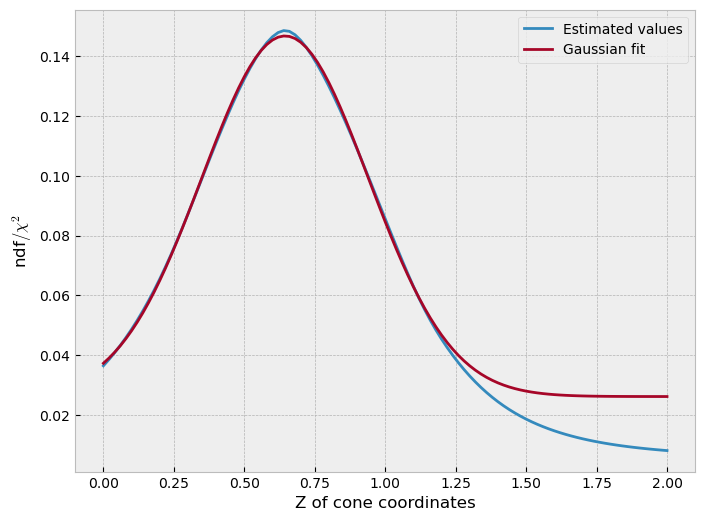

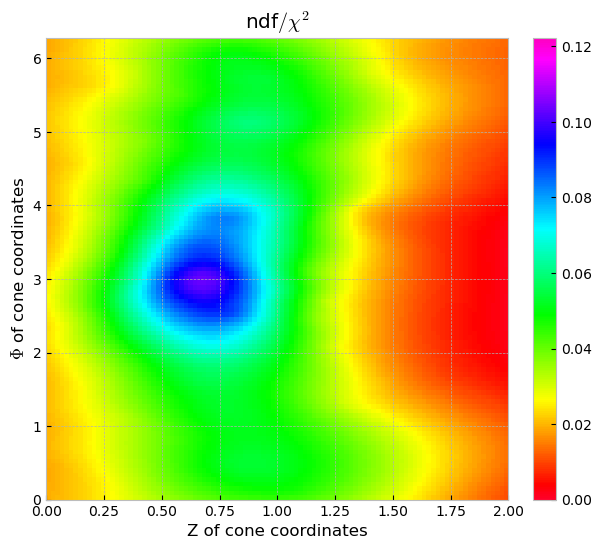

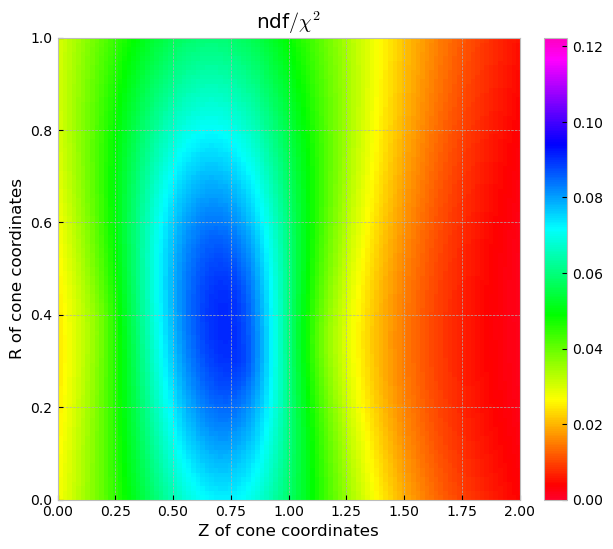

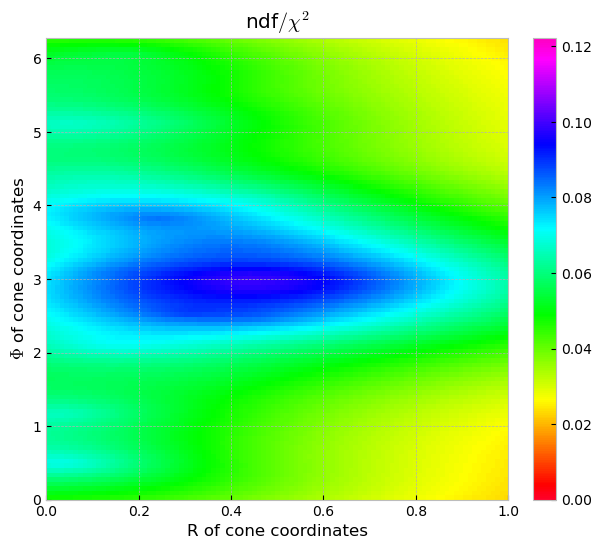

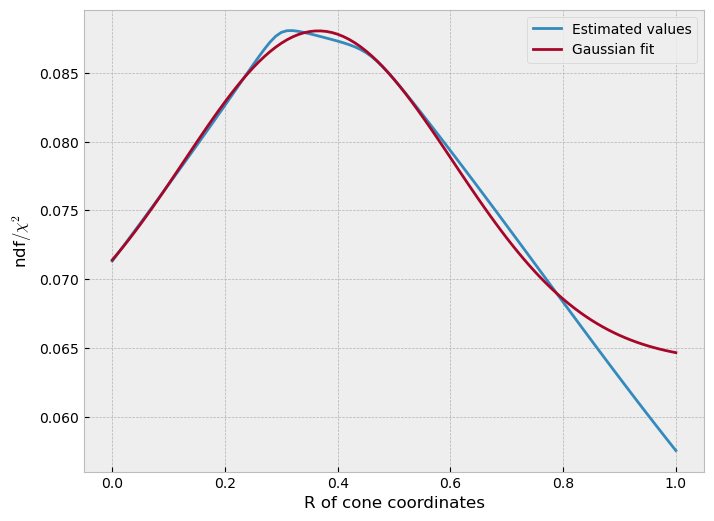

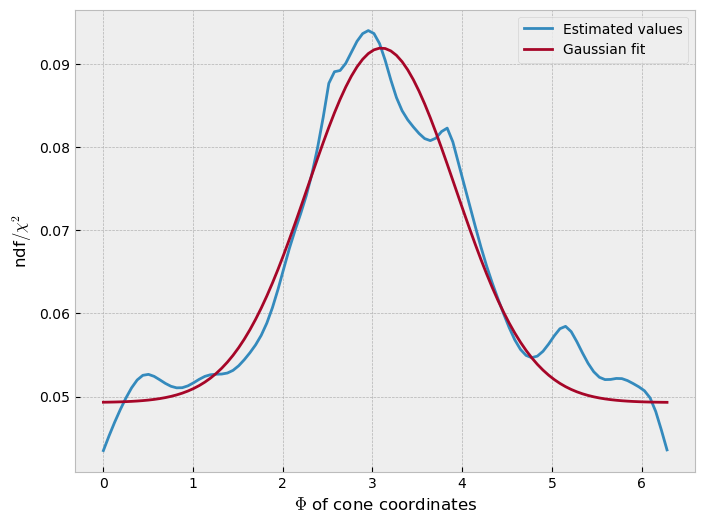

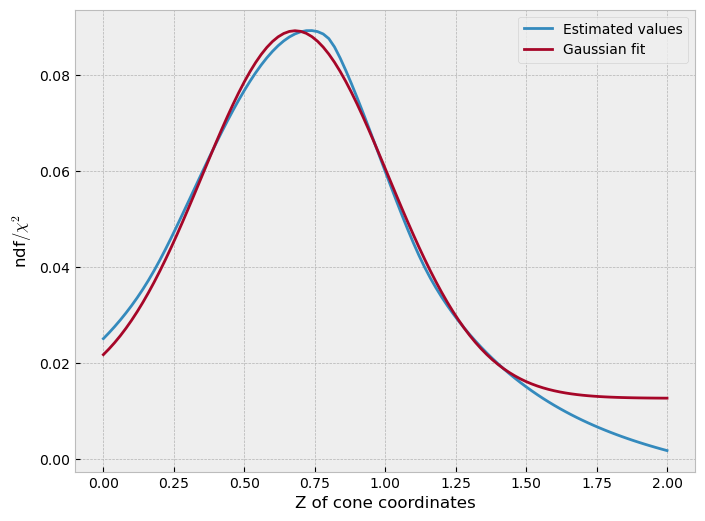

In [19]:
for HIST_INDEX in range(6):
    allHistsMC = []

    c_sorted, train_x_sorted, predictive_mean = fit_bo(HIST_INDEX)
    predictive_mean_2 = predictive_mean - predictive_mean.min()
    print(c_sorted[-5:])

    fig, ax = plt.subplots(nrows=1, ncols=3, sharey=False)
   # convert_to_h3d(predictive_mean, HIST_INDEX)
    #interact(f, x=FloatSlider(description=axis_titles[0], min=0.0, max=1.0, step=0.01, value=train_x_sorted[-1][0], layout=Layout(width='500px')))
    f(ax[0], train_x_sorted[-1][0])
   # plt.savefig("chi2_bestR_" + str(HIST_INDEX) + ".png")
    #interact(g, x=FloatSlider(description=axis_titles[1], min=0.0, max=2*math.pi, step=0.01, value=train_x_sorted[-1][1], layout=Layout(width='500px')))
    g(ax[1], train_x_sorted[-1][1])
   # plt.savefig("chi2_bestPhi_" + str(HIST_INDEX) + ".png")
    #interact(h, x=FloatSlider(description=axis_titles[2], min=0.0, max=2, step=0.01, value=train_x_sorted[-1][2], layout=Layout(width='500px')))
    h(ax[2], train_x_sorted[-1][2])
   # plt.savefig("chi2_bestZ_" + str(HIST_INDEX) + ".png")

    bestIndex = int(c_sorted[-1][0].item())
    can1, hdiff1, py1 = plotComparison(allHistsMC[bestIndex], histsData[0][HIST_INDEX])
    can1.SaveAs("comparison_bestIndex_" + str(HIST_INDEX) + ".gif")

    worstIndex = int(c_sorted[0][0].item())
    can2, hdiff2, py2 = plotComparison(allHistsMC[worstIndex], histsData[0][HIST_INDEX])
    can2.SaveAs("comparison_worstIndex_" + str(HIST_INDEX) + ".gif")

    all = all_lambdas(xs)
    cov_lambda = np.cov(all, rowvar=False, aweights=predictive_mean_2)
    sgn_lambda = 1.0*(cov_lambda > 0) + -1.0*(cov_lambda < 0)

    np.multiply(
        sgn_lambda, np.sqrt(
            np.multiply(
                sgn_lambda, cov_lambda
            )
        )
    )
    print(str(HIST_INDEX) + ": Final result:")
    print(str(HIST_INDEX) + ": lambdas = ", c_sorted[-1][1:4])
   # print(str(HIST_INDEX) + ": covariance matrix: \n", cov_lambda)

   # hpm = convert_to_h3d(predictive_mean, HIST_INDEX)
   # covariance_fit(hpm,train_x_sorted[-1],HIST_INDEX)
    drphiz = covariance_fit_scipy(predictive_mean,train_x_sorted[-1],HIST_INDEX)

    print(str(HIST_INDEX) + ": errors = ", lambda_errors(train_x_sorted[-1], drphiz))

    
#allHistsMC = []
#for ind in range(1):
#    task(ind)

#with multiprocessing.Pool() as pool:
#    pool.map(task, range(3))